<a href="https://colab.research.google.com/github/PhilipPfeffer/haptic_vest/blob/main/data_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Pipeline

#Import Data

In [1]:
from pycocotools.coco import COCO     # https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/coco.py
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
# import pylab


In [2]:
rel_path='..'
datasetName='val2017'
annotations=f'/content/drive/My Drive/Haptic Vest/coco_dataset/annotations/instances_{datasetName}.json'
print(annotations)

/content/drive/My Drive/Haptic Vest/coco_dataset/annotations/instances_val2017.json


In [3]:
# This line loads annotations from an instances_{datasetName}.json file into a COCO object so we can use the pycoco API
coco = COCO(annotations)

loading annotations into memory...
Done (t=2.23s)
creating index...
index created!


In [4]:
# Display COCO categories and supercategories
#  - catIds: are numbers associated with each category (e.g. 1 = person, person, 2 = vehicle, bicycle, ...)
#  - cats: are the names of each category
catIds = coco.getCatIds()
cats = coco.loadCats(catIds)

category_names = [cat['name'] for cat in cats]
print(f"There are {len(category_names)} categories.")
print(f"COCO categories: \n{' '.join(category_names)}\n")

supercategory_names = set([cat['supercategory'] for cat in cats])
print(f"There are {len(supercategory_names)} supercategories.")
print(f"COCO supercategories: \n{' '.join(supercategory_names)}")

There are 80 categories.
COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

There are 12 supercategories.
COCO supercategories: 
indoor sports kitchen appliance food person animal electronic outdoor vehicle accessory furniture


In [35]:
####################################################
# Helper function that gets the category name 
# given its id.
####################################################
def get_cat_name(category_names, cat_id=1):
  return category_names[person_cat_id[0]-1]

get_cat_name(category_names, 1)

'person'

# Sort data

## Images with people in them

In [54]:
####################################################
# Choosing a category:
# USAGE: get_chosen_cat_data(coco, cat_name)
# 1. Gets all the images in the dataset that have a
#    given category.
# 2. Gets all the annotations of that category in 
#    those images.
# 3. Also gets other stuff, look at the last line
####################################################

def get_chosen_cat_id(coco, cat_name='person'):
  chosen_cat_id = coco.getCatIds(catNms=[cat_name])[0];   # returns 1 for 'person'
  return chosen_cat_id

def get_chosen_cat_img_ids(coco, chosen_cat_id):
  chosen_cat_img_ids = coco.getImgIds(catIds=chosen_cat_id)
  return chosen_cat_img_ids

def get_chosen_annotation_ids(coco, chosen_cat_img_ids, chosen_cat_id):
  chosen_cat_annotation_ids = coco.getAnnIds(imgIds=chosen_cat_img_ids, catIds=chosen_cat_id)
  return chosen_cat_annotation_ids

def get_chosen_cat_annotations(coco, chosen_cat_annotation_ids):
  chosen_cat_annotations = coco.loadAnns(chosen_cat_annotation_ids)
  return chosen_cat_annotations

def get_chosen_cat_img_data(coco, chosen_cat_img_ids):
  chosen_cat_imgs_data = coco.loadImgs(chosen_cat_img_ids)
  return chosen_cat_imgs_data

def get_chosen_cat_data(coco, chosen_cat_name='person'):
  chosen_cat_id = get_chosen_cat_id(coco, chosen_cat_name)
  chosen_cat_img_ids = get_chosen_cat_img_ids(coco, chosen_cat_id)
  chosen_cat_imgs_data = get_chosen_cat_img_data(coco, chosen_cat_img_ids)
  chosen_cat_annotation_ids = get_chosen_annotation_ids(coco, chosen_cat_img_ids, chosen_cat_id)
  chosen_cat_annotations = get_chosen_cat_annotations(coco, chosen_cat_annotation_ids)
  print(f"There are {len(chosen_cat_img_ids)} images with a {chosen_cat_name} in them in the \"{datasetName}\" dataset.")
  print(f"Within those images, there are {len(chosen_cat_annotations)} {chosen_cat_name} annotations.")    # Note: there are more annotations than images because each image has >1 annotation
  return (chosen_cat_id, chosen_cat_img_ids, chosen_cat_imgs_data, chosen_cat_annotation_ids, chosen_cat_annotations)

chosen_cat_id, chosen_cat_img_ids, chosen_cat_imgs_data, chosen_cat_annotation_ids, chosen_cat_annotations = get_chosen_cat_data(coco, 'person')

There are 2693 images with a person in them in the "val2017" dataset.
Within those images, there are 11004 person annotations.


In [55]:
####################################################
# Checks that all the annotations are one category
####################################################

def check_all_anns_cat(person_annotations, category_names, cat_id=1):
  if cat_id ==0:
    print("We don't check for backgrounds, you're passing cat_id = 0.")

  cat_name = category_names[cat_id-1]   # offset because cat_names doesn't include 0=background 
  not_cat = False
  for ann in person_annotations: 
    if (ann['category_id'] != cat_id): 
      not_cat = True
      break
  if not_cat:
    print(f"One of the annotations is not a {cat_name}.")
  else:
    print(f"All of the annotations are a {cat_name}.")

check_all_anns_cat(chosen_cat_annotations, category_names, chosen_cat_id)

All of the annotations are a person.


In [39]:
####################################################
# Get images of all people with an area percentage
####################################################
# Variables to play with: threshold percentage area
areaRngLowerBound = 6000
areaRngUpperBound = float('inf')
####################################################

person_pctarea = {ann['image_id'] : ann['area']/(person_imgs_data[i]['height']*person_imgs_data[i]['width']) for i, ann in enumerate(person_annotations)}
# person_image_size = {img_data['id']:  for img_data in person_imgs_data}

# print(f"There are {len(person_annotation_ids)} people within the specified area range.")

# person_pct = {image_id: np.round(person_imgId_to_area[image_id]/person_image_size[image_id],2) for image_id in person_image_size}
print(person_pctarea)


# Example: display the first person in the list with their annotations
# Note: we can display each labelled pixel or the bounding box
print("\nHere is one of them with the pixel segmentation and bounding box displayed:")
first_person_annotations = person_annotations[0]
first_person_img_id = first_person_annotations['image_id']
first_person_img = coco.loadImgs(first_person_img_id)[0]
io.imshow(io.imread(first_person_img['coco_url']))
coco.showAnns([first_person_annotations], draw_bbox=True)

IndexError: ignored

In [ ]:
####################################################
# Example of loading an image from the URL [COMMENTED]
####################################################
# np.random.seed(1)   # for debugging purposes
# catIds = coco.getCatIds(catNms=['person']);
# imgIds = coco.getImgIds(catIds=catIds );

# # Load image with URL (using io)
# img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
# person_rand_img = io.imread(img['coco_url'])
# io.imshow(person_rand_img)

# # NOTE: Can also use matplotlib
# # plt.axis('off')
# # plt.imshow(person_rand_img)
# # plt.show()


#Resize and Convert to Greyscale

In [ ]:
from skimage.color import rgb2gray
from skimage.transform import resize

(96, 96)

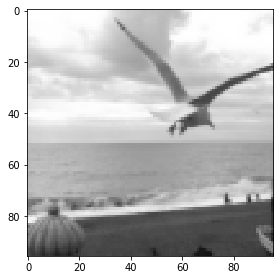

In [ ]:
grey96 = rgb2gray(resize(person_rand_img, (96,96)))
io.imshow(grey96)
np.array(grey96).shape